In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd
import pickle

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs
from configs import states_per_site

# Parameters and Initialization

In [2]:
np.random.seed(0)

In [3]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100
load = True

In [4]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
std_scaling=1.
mu_scaling=0.2

In [5]:
def nb(mu, std_scaling=std_scaling, mu_scaling=mu_scaling):
    """ mu is a vector of firing rates. std_scaling is a scalar. """


    mu = mu*mu_scaling + 1E-8
    std = std_scaling * np.sqrt(mu)
    std += 1E-8
    n = (mu**2)/(std**2 - mu)
    p = mu/(std**2)
    try:
        nb_mu = nbinom.rvs(n, p)
    except:
        print(n)
        print(p)
        import pdb; pdb.set_trace()
    return nb_mu.astype(float)


def nb_corr(a, b):
    nb_a = nb(a)
    nb_b = nb(b)
    return np.corrcoef(nb_a, nb_b)[0, 1]

# Run Task (with learning)

In [6]:
def run():
    # Set up
    model = Model(N_inp, N_bar, num_states, steps=steps)
    site_locations = np.arange(0, 100, states_per_site)
    cache_states = np.random.choice(site_locations, 3)
    model.reset()
    cache_acts = []

    # Run learning
    for cache_state in cache_states:
        print("Now I just cached at location:", cache_state)
        preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs)
        model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
        cache_acts.append(acts_over_time[-1, cache_state].copy())

    # Get retrieval activation
    _, _, output, retrieval_acts_over_time = model.run_recall(0., place_inputs)
    retrieval_acts = retrieval_acts_over_time[-1]

    # Place activity
    _, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
    place_mean = np.mean(place_acts, axis=0).flatten()
    place_std = np.std(place_acts, axis=0).flatten()

    # Cache activity
    cache_acts = np.array(cache_acts)
    
    # If anything with NaNs, skip
    if np.any(np.isnan(cache_acts)):
        return None, None
    if np.any(np.isnan(retrieval_acts)):
        return None, None
    if np.any(np.isnan(place_acts)):
        return None, None

    # Collect data
    cache_cache_corr = {'Distance': [], 'Correlation': []}
    cache_visit_corr = {'Distance': [], 'Correlation': []}
    visit_visit_corr = {'Distance': [], 'Correlation': []}
    cache_retrieval_corr = {'Distance': [], 'Correlation': []}

    for i in range(len(cache_states)):
        for j in range(i, len(cache_states)):
            _distance = distance(cache_states[i], cache_states[j], num_states)

            cache_act_i = cache_acts[i].copy()
            cache_act_j = cache_acts[j].copy()
            retrieval_act_j = retrieval_acts[cache_states[j]].copy()
            place_act_i = place_acts[cache_states[i]].copy()
            place_act_j = place_acts[cache_states[j]].copy()

            for _ in range(3): # More samples
                c_c_corr = nb_corr(cache_act_i, cache_act_j)
                c_v_corr = nb_corr(cache_act_i, place_act_j)
                v_v_corr = nb_corr(place_act_i, place_act_j)
                c_r_corr = nb_corr(cache_act_i, retrieval_act_j)

                cache_cache_corr['Distance'].append(_distance)
                cache_cache_corr['Correlation'].append(c_c_corr)

                cache_visit_corr['Distance'].append(_distance)
                cache_visit_corr['Correlation'].append(c_v_corr)

                visit_visit_corr['Distance'].append(_distance)
                visit_visit_corr['Correlation'].append(v_v_corr)

                cache_retrieval_corr['Distance'].append(_distance)
                cache_retrieval_corr['Correlation'].append(c_r_corr)

    visit_visit_df = pd.DataFrame(visit_visit_corr)
    cache_retrieve_df = pd.DataFrame(cache_retrieval_corr)
    norm_constant = np.mean(
       visit_visit_df[visit_visit_df['Distance']==0]['Correlation'])
    visit_visit_df['Correlation'] = visit_visit_df['Correlation'].div(norm_constant)
    cache_retrieve_df['Correlation'] = cache_retrieve_df['Correlation'].div(norm_constant)
    
    return visit_visit_df, cache_retrieve_df

# Collect

In [7]:
if load:
    with open('pickles/fig3e_correlations.p', 'rb') as f:
        results = pickle.load(f)
    visit_visit_df = results['visit_visit_df']
    cache_retrieve_df = results['cache_retrieve_df']
else:
    iters = 30
    n_samples = 0
    visit_visit_df = []
    cache_retrieve_df = []
    while n_samples < iters:
        v, c = run()
        if v is None:
            print('Error. Re-running.')
            continue
        print(f'Iteration {n_samples} completed.')
        visit_visit_df.append(v)
        cache_retrieve_df.append(c)
        n_samples += 1
    visit_visit_df = pd.concat(visit_visit_df)
    cache_retrieve_df = pd.concat(cache_retrieve_df)
    with open('pickles/fig3e_correlations.p', 'wb') as f:
        pickle.dump({
            'visit_visit_df': visit_visit_df,
            'cache_retrieve_df': cache_retrieve_df
            }, f)

# Plot

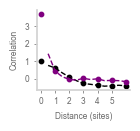

In [8]:
fig, ax = plt.subplots(figsize=(1.45, 1.35))
for df, color in zip(
    [visit_visit_df, cache_retrieve_df],
    ['black', 'purple']):

    dists = []
    corrs = []
    for dist in np.sort(np.unique(df['Distance'])):
        _df = df[df['Distance']==dist]
        corr = np.mean(_df['Correlation'])
        dists.append(dist)
        corrs.append(corr)
    plt.scatter(
        dists[::2], corrs[::2], color=color, s=10)
    plt.plot(
        dists[1:], corrs[1:],
        color=color,
        linewidth=1., linestyle='--')
    
plt.xticks([0, 8, 16, 24, 32, 40],
           [0, 1, 2, 3, 4, 5],
           fontsize=6)
plt.xlabel('Distance (sites)', fontsize=6)
plt.ylabel('Correlation', fontsize=6)
plt.tight_layout()
plt.yticks([0, 1, 2, 3], fontsize=6)
plt.savefig('figures/fig3e.svg', dpi=300, transparent=True)
plt.show()